In [2]:
from util.datagen import generator
from util.model import build_seg_model
from cfg import *

import segmentation_models as sm
sm.set_framework('tf.keras')
import tensorflow.keras.backend as k
import gc
from albumentations import *
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

Segmentation Models: using `keras` framework.


In [3]:
import os, glob, datetime
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import tensorflow as tf
import IPython
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img, array_to_img
import PIL
from PIL import ImageOps
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (10,8)

In [4]:
import os, glob, datetime
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import tensorflow as tf
import IPython
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img, array_to_img
import PIL
from PIL import ImageOps
#os.environ["CUDA_VISIBLE_DEVICES"] = '0'

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (10,8)

2 Physical GPUs, 2 Logical GPUs


In [5]:
CLASS_NAME='multi'
if CLASS_NAME=='nerve':
    TRUE_LABEL_LIST = [
        {'label':2,'restrict':0},
        {'label':3,'restrict':0}
    ]
    ZERO_LABEL_LIST = [
        {'label':1,'restrict':5},
        {'label':4,'restrict':10}
    ]
elif CLASS_NAME=='tumor':
    TRUE_LABEL_LIST = [
    {'label':1,'restrict':0}
    ]
    ZERO_LABEL_LIST = [
        {'label':2,'restrict':50},
        {'label':3,'restrict':50},
        {'label':4,'restrict':100}
    ]
else:
    TRUE_LABEL_LIST = [
        {'label':1,'restrict':100},
        {'label':2,'restrict':100},
        {'label':3,'restrict':100},
        {'label':4,'restrict':100}
    ]
    ZERO_LABEL_LIST = [] 

In [6]:
ALL_ZIP = []
for path in ALL_SLIDE_PATHS:
    slide_name = path.split('/')[-1].replace('.tiff','').replace('.svs','')
    patient_path = '/'.join(path.split('/')[:-1]) + '/'
    for lbl in TRUE_LABEL_LIST :
        target_list = glob.glob(patient_path+f'{PATCH_NAME}/mask/{slide_name}*_p{lbl["label"]}.png')
        if lbl['restrict']==0:
            ALL_ZIP.extend(target_list) 
        else:
            ALL_ZIP.extend(shuffle(target_list,random_state = 311)[:lbl["restrict"]])
    for lbl in ZERO_LABEL_LIST :
        target_list = glob.glob(patient_path+f'{PATCH_NAME}/mask/{slide_name}*_p{lbl["label"]}.png')
        ALL_ZIP.extend(shuffle(target_list,random_state = 311)[:lbl["restrict"]])
ALL_ZIP = shuffle([('/'.join(x.split('/')[:-2])+'/image/'+re.sub('_p[0-9]','',x.split('/')[-1]),x) for x in ALL_ZIP],random_state=311)

TRAIN_ZIP  = ALL_ZIP[:int(0.66*len(ALL_ZIP))]
VALID_ZIP  = ALL_ZIP[int(0.66*len(ALL_ZIP)):int(0.88*len(ALL_ZIP))]
TEST_ZIP  = ALL_ZIP[int(0.88*len(ALL_ZIP)):]

ZERO_LABELS = [x['label'] for x in ZERO_LABEL_LIST]


In [7]:
te_1 = 0; te_2 = 0; te_3 = 0 ; te_4 = 0

for tup in TEST_ZIP:
    x = tup[-1][-5]
    if x=='1':
        te_1+=1
    elif x=='2':
        te_2+=1
    elif x=='3':
        te_3+=1
    else:
        te_4+=1
print(f'TEST PATCH CLASS\nTUMOR : {te_1 } NERVE : {te_2+te_3} NORMAL : {te_4}')

TEST PATCH CLASS
TUMOR : 724 NERVE : 122 NORMAL : 75


In [8]:
if CLASS_NAME=='multi':
    binary=False
else:
    binary=True
    
test_set = generator(
    zip_path_list=TEST_ZIP,
    batch_size=BATCH_SIZE,
    zero_labels = ZERO_LABELS,
    is_train=False,
    binary=binary
)

---

In [10]:
from util.model import *
import pandas as pd

In [11]:
it = iter(test_set)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


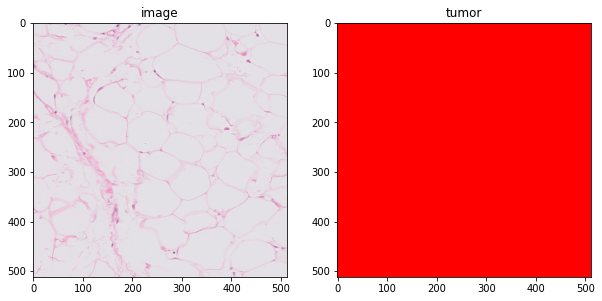

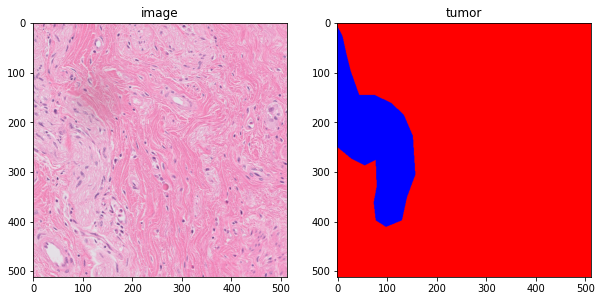

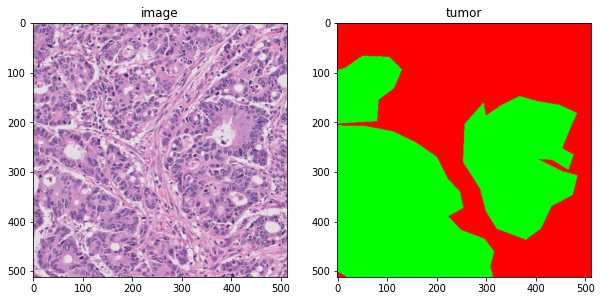

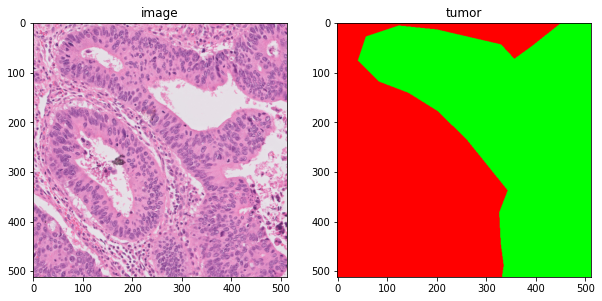

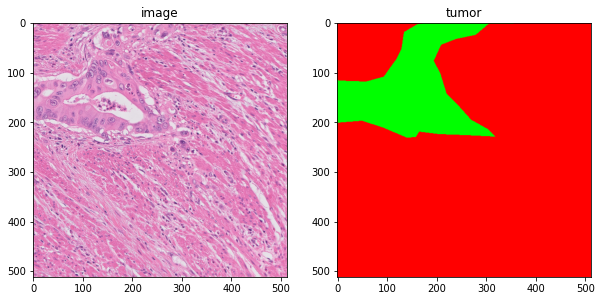

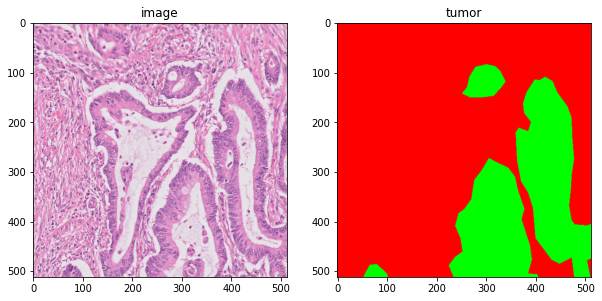

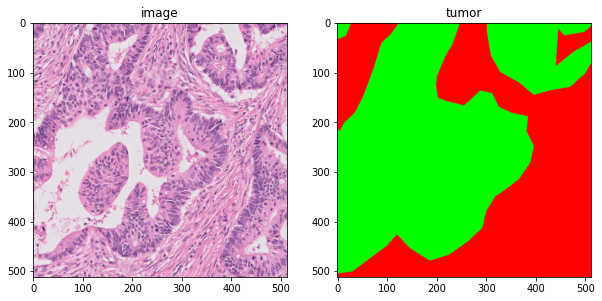

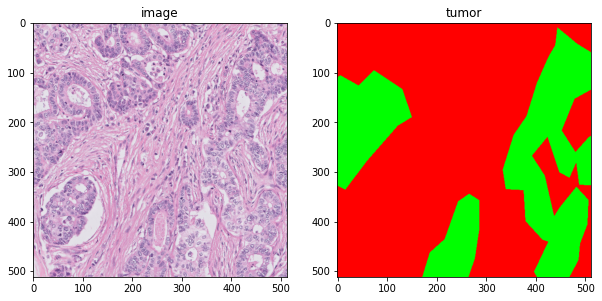

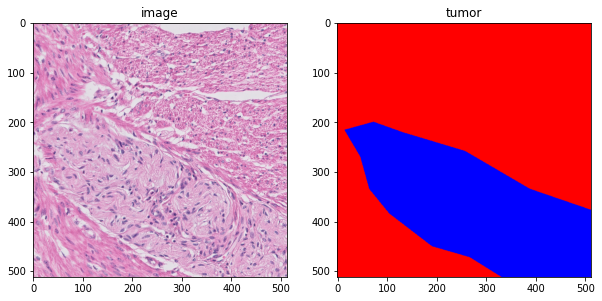

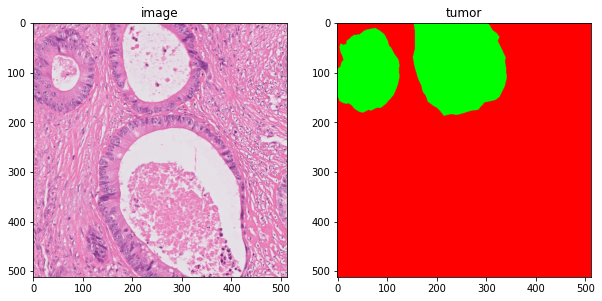

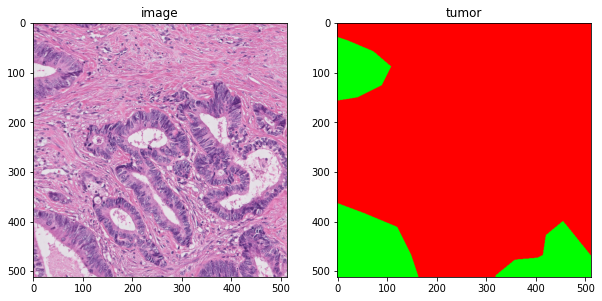

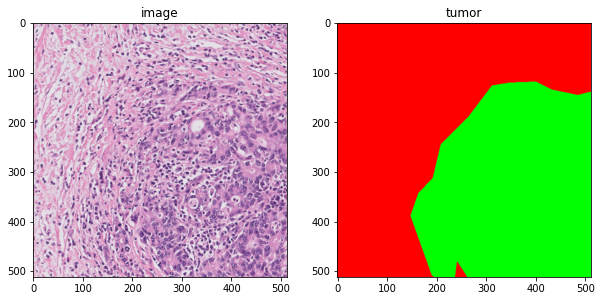

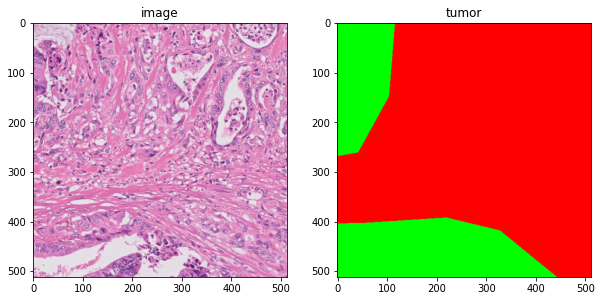

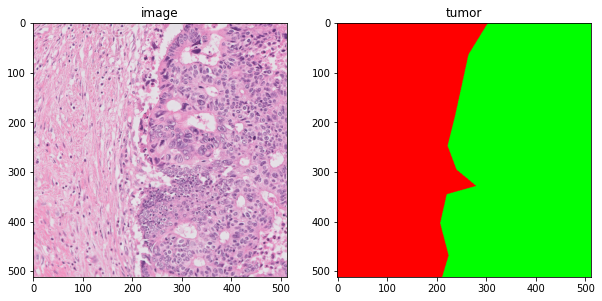

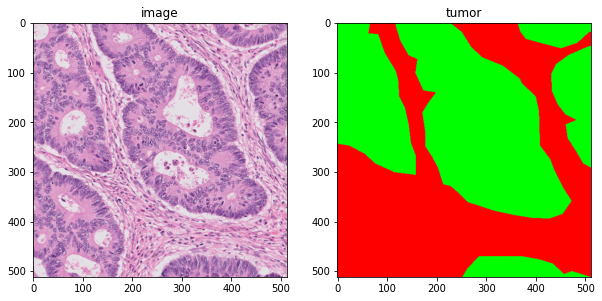

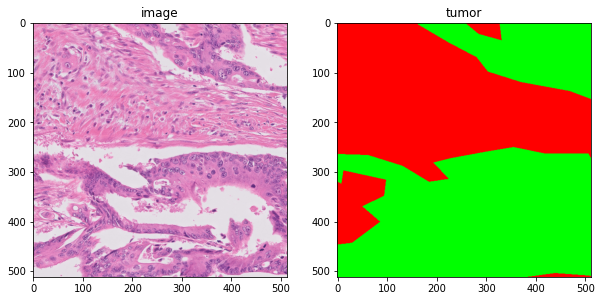

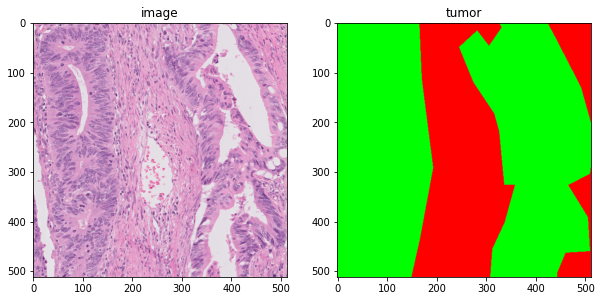

In [ ]:
batch_x, batch_y = next(it)
for i in range(32):
    plt.figure()
    plt.subplot(1,2,1); plt.title('image'); plt.imshow(batch_x[i])
    plt.subplot(1,2,2); plt.title('tumor'); plt.imshow(np.array(batch_y[i]))
    #plt.subplot(1,3,3); plt.title('nerve'); plt.imshow(np.array(batch_y[i][...,1]))

In [128]:
mdl_paths = glob.glob(f'./model/{CLASS_NAME}_{MAGNIFICATION}_*efficientnetb0_*.hdf5')
#mdl_paths = glob.glob(f'./model/{CLASS_NAME}*')
mdls = [x.split('_')[2] for x in mdl_paths]
backbones = [x.split('_')[3] for x in mdl_paths]
weights = ['pascal_voc' if x=='xception' else 'imagenet' for x in backbones]
mdl_paths
#print(mdls, backbones, weights)

['./model/multi_100_unet_efficientnetb0_imagenet_1108_focal.hdf5',
 './model/multi_100_unet_efficientnetb0_imagenet_1109_focal.hdf5',
 './model/multi_100_unet_efficientnetb0_imagenet_1110_focal.hdf5',
 './model/multi_100_unet_efficientnetb0_imagenet_1022_focal.hdf5',
 './model/multi_100_unet_efficientnetb0_imagenet_1028_focal.hdf5',
 './model/multi_100_unet_efficientnetb0_imagenet_1103_focal.hdf5']

In [67]:
#mdl_paths.pop(-4)


In [129]:
mdl_paths

['./model/multi_100_unet_efficientnetb0_imagenet_1108_focal.hdf5',
 './model/multi_100_unet_efficientnetb0_imagenet_1109_focal.hdf5',
 './model/multi_100_unet_efficientnetb0_imagenet_1110_focal.hdf5',
 './model/multi_100_unet_efficientnetb0_imagenet_1022_focal.hdf5',
 './model/multi_100_unet_efficientnetb0_imagenet_1028_focal.hdf5',
 './model/multi_100_unet_efficientnetb0_imagenet_1103_focal.hdf5']

In [130]:
splitted = mdl_paths[1].split('/')[-1].split('_')

In [131]:
if CLASS_NAME=='multi':
    dice_loss = sm.losses.DiceLoss(per_image=True,smooth=1e+0,class_weights=np.array([0.4,0.75,2.5]))
    focal_loss = sm.losses.CategoricalFocalLoss(alpha = 0.25, gamma = 6.0)
else:
    dice_loss = sm.losses.DiceLoss(smooth=1e+0)
    focal_loss = sm.losses.BinaryCELoss()
loss = dice_loss + focal_loss

optim = Adam(INITIAL_LEARNING_RATE)
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5),sm.metrics.Recall(),sm.metrics.Precision(),tf.keras.metrics.BinaryAccuracy()]

In [132]:
i = 0
if CLASS_NAME=='multi':
    activation='softmax'; n_classes = 3
else:
    activation='sigmoid'; n_classes = 1

In [133]:
df = pd.DataFrame(columns = ['model','class_name','model_path','encoder','encoder_freeze','decoder','loss','iou','fscore','recall','precision','pixel_acc'])

In [134]:
csv_path = f'unets_{CLASS_NAME}.csv'
for i, mdl_path in enumerate(mdl_paths):
    splitted = mdl_path.split('/')[-1].split('_')
    mdl = splitted[2]; cls_name = splitted[0]; encoder = splitted[3]
    if splitted[4]!='imagenet':
        encoder_fr = splitted[4]; decoder = splitted[5]; 
    else:
        encoder_fr = 'freeze'; decoder = 'upsampling'
    append_row = [mdl,cls_name,mdl_path,encoder,encoder_fr,decoder]
    
    '''model = sm.Unet(
        backbone_name=encoder,
        input_shape=INPUT_SHAPE,
        classes=n_classes,
        encoder_weights='imagenet',
        encoder_freeze=True if encoder_fr=='freeze' else False,
        decoder_block_type=decoder
    )'''
    model = build_seg_model(
        mdls[i],
        backbone=backbones[i],
        weight=weights[i],
        input_shape=(512, 512, 3),
        activation=activation,
        n_classes=n_classes,
        decoder='upsampling',
        freeze=True,
    )
    model.load_weights(mdl_path)
    model.compile(optim,loss,metrics)
    
    eval_result = model.evaluate(test_set)
    append_row.extend(eval_result)
    df.loc[i,:] = append_row
print(df.head())
df.to_csv(csv_path)

28/28 [==============================] - 10s 247ms/step - loss: 0.1340 - iou_score: 0.7276 - f1-score: 0.8375 - recall: 0.8538 - precision: 0.8361 - binary_accuracy: 0.8942
  model class_name                                         model_path  \
0  unet      multi  ./model/multi_100_unet_efficientnetb0_imagenet...   
1  unet      multi  ./model/multi_100_unet_efficientnetb0_imagenet...   
2  unet      multi  ./model/multi_100_unet_efficientnetb0_imagenet...   
3  unet      multi  ./model/multi_100_unet_efficientnetb0_imagenet...   
4  unet      multi  ./model/multi_100_unet_efficientnetb0_imagenet...   

          encoder encoder_freeze     decoder       loss       iou    fscore  \
0  efficientnetb0         freeze  upsampling   0.127857  0.501524  0.570749   
1  efficientnetb0         freeze  upsampling   0.119507  0.734164   0.84209   
2  efficientnetb0         freeze  upsampling  0.0245713  0.769327   0.86541   
3  efficientnetb0         freeze  upsampling   0.188625   0.68118  0.805

In [136]:
df2 = df[['model','class_name','encoder','encoder_freeze','decoder','loss','iou','fscore','recall','precision','pixel_acc']]
df2

model class_name         encoder encoder_freeze     decoder       loss  \
0  unet      multi  efficientnetb0         freeze  upsampling   0.127857   
1  unet      multi  efficientnetb0         freeze  upsampling   0.119507   
2  unet      multi  efficientnetb0         freeze  upsampling  0.0245713   
3  unet      multi  efficientnetb0         freeze  upsampling   0.188625   
4  unet      multi  efficientnetb0         freeze  upsampling   0.194501   
5  unet      multi  efficientnetb0         freeze  upsampling   0.133972   

        iou    fscore    recall precision pixel_acc  
0  0.501524  0.570749  0.583441  0.887687  0.910946  
1  0.734164   0.84209  0.854166  0.837495  0.903807  
2  0.769327   0.86541  0.874592  0.859546  0.907386  
3   0.68118  0.805832  0.869812  0.772108  0.898891  
4  0.693658  0.813279  0.847003  0.796575  0.895527  
5  0.727559  0.837549  0.853814  0.836113  0.894196

In [30]:
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


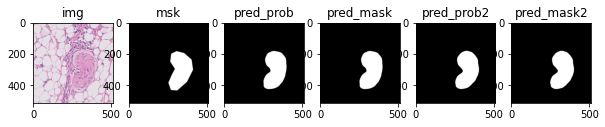

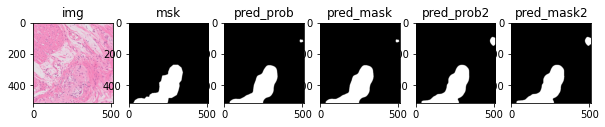

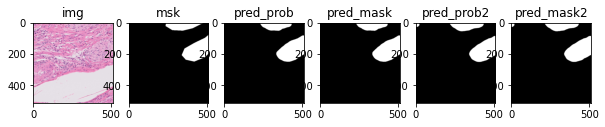

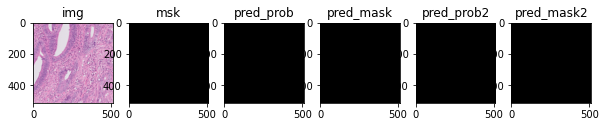

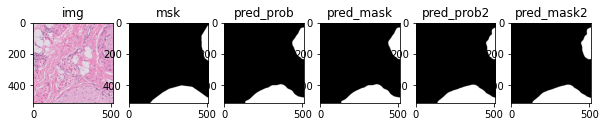

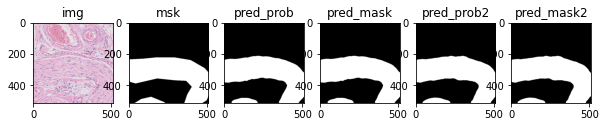

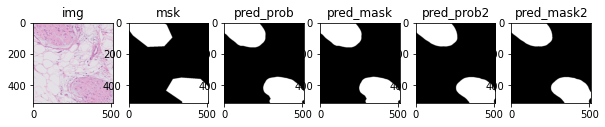

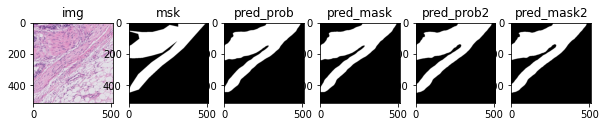

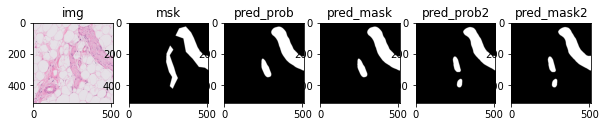

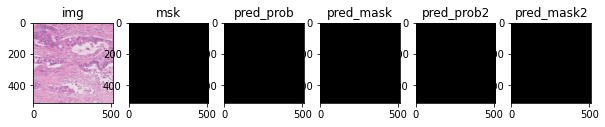

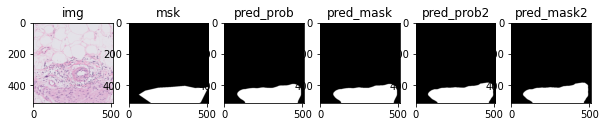

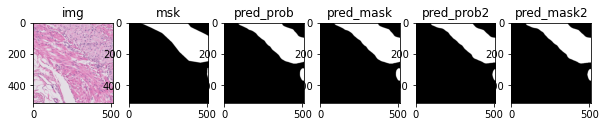

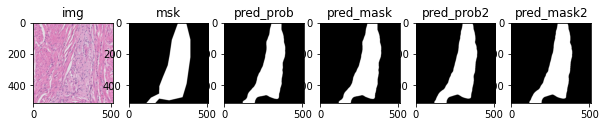

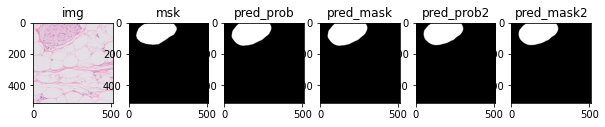

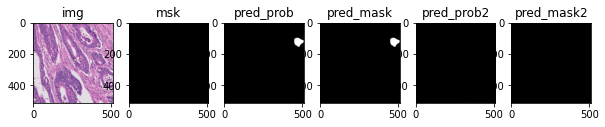

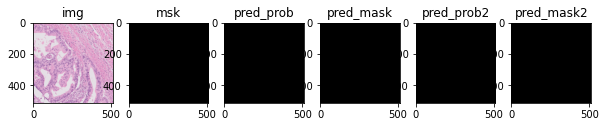

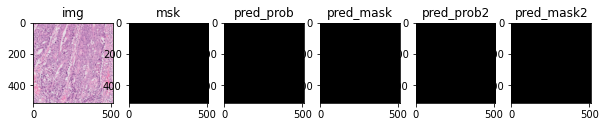

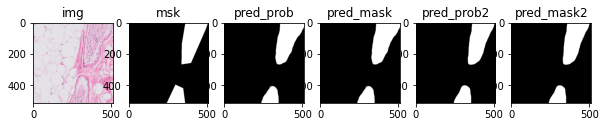

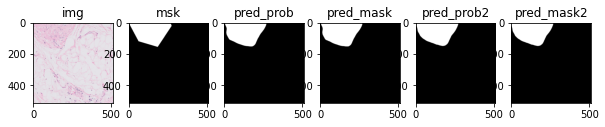

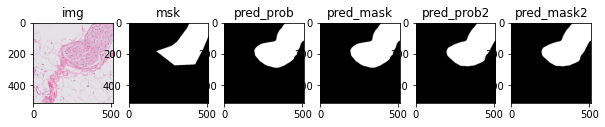

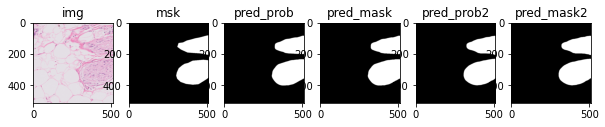

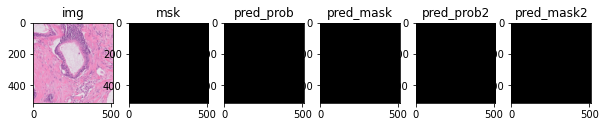

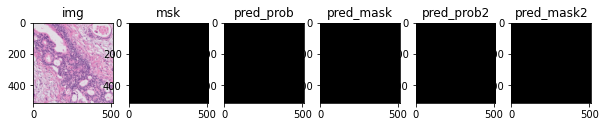

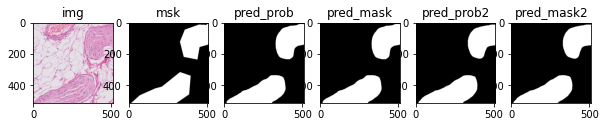

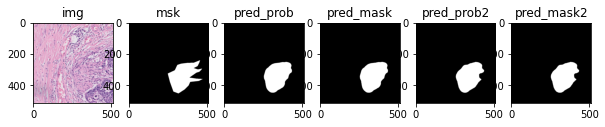

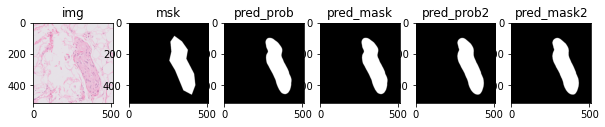

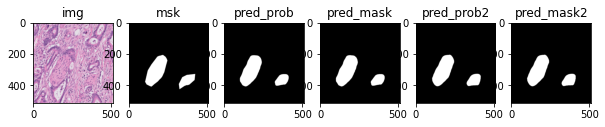

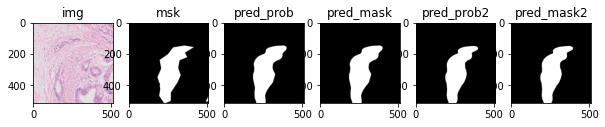

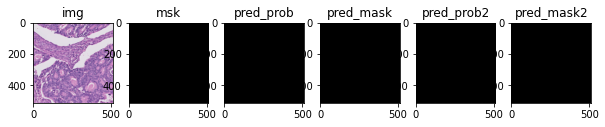

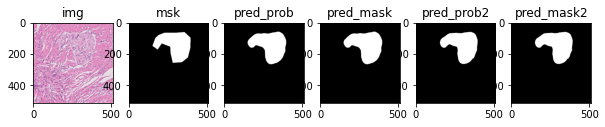

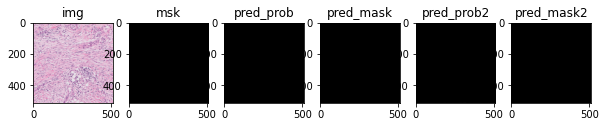

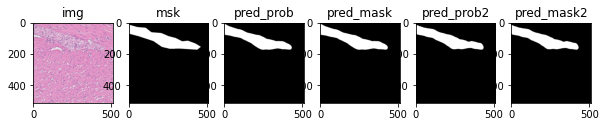

In [29]:
mdl = sm.Unet(
        backbone_name='seresnext101',
        input_shape=INPUT_SHAPE,
        classes=1,
        encoder_weights='imagenet',
        encoder_freeze=True,
        decoder_block_type='attention'
)
mdl.load_weights('./model/nerve_100_unet_seresnext101_freeze_attention_imagenet_1116_ce.hdf5')
mdl2 = sm.Unet(
        backbone_name='seresnext101',
        input_shape=INPUT_SHAPE,
        classes=1,
        encoder_weights='imagenet',
        encoder_freeze=True,
        decoder_block_type='upsampling'
)
mdl2.load_weights('./model/nerve_100_unet_seresnext101_freeze_upsampling_imagenet_1116_ce.hdf5')
batch_set = test_set.take(1)
for img_batch,msk_batch in batch_set:
    for i in range(32):
        img_input = np.expand_dims(img_batch[i],axis =0)
        pred_prob = np.squeeze(mdl.predict(img_input))
        pred_mask = np.logical_and(pred_prob>0.5,1)
        
        pred_prob2 = np.squeeze(mdl2.predict(img_input))
        pred_mask2 = np.logical_and(pred_prob2>0.5,1)
        
        plt.figure()
        plt.subplot(1,6,1); plt.title('img') ; plt.imshow(img_batch[i])
        plt.subplot(1,6,2); plt.title('msk') ; plt.imshow(msk_batch[i])
        plt.subplot(1,6,3); plt.title('pred_prob') ; plt.imshow(pred_prob)
        plt.subplot(1,6,4); plt.title('pred_mask') ; plt.imshow(pred_mask)
        plt.subplot(1,6,5); plt.title('pred_prob2') ; plt.imshow(pred_prob2)
        plt.subplot(1,6,6); plt.title('pred_mask2') ; plt.imshow(pred_mask2)
        
        

In [29]:
test_df = pd.DataFrame(columns = ['model','backbone','loss','iou','fscore','recall','precision'])

In [30]:
i = 0
if CLASS_NAME=='multi':
    activation='softmax'; n_classes = 3
else:
    activation='sigmoid'; n_classes = 1
for idx in range(len(mdl_paths)):
    try:
        mdl_path = mdl_paths[idx]; 
        mdl_st = mdls[idx]
        backbone = backbones[idx]; 
        weight = weights[idx]
        append_row = [mdl_st,backbone]
        print(mdl_st,backbone,weight,activation,n_classes)
        mdl = build_seg_model(
            model = mdl_st,
            backbone=backbone,
            weight=weight,
            activation=activation,
            n_classes = n_classes
        )
        mdl.load_weights(mdl_path)
        mdl.compile(optim,loss,metrics)
        print(f'MODEL : {mdl_path}')
        eval_res = mdl.evaluate(test_set)
        append_row.extend(eval_res)
        test_df.loc[i,:] = append_row
        i+=1
    except Exception as e:
        print(e)
        continue
    if (idx+1)%5==0:
        print(f'{idx+1} Doing')

unet efficientnetb0 imagenet sigmoid 1
You are trying to load a weight file containing 151 layers into a model with 183 layers.
unet efficientnetb3 imagenet sigmoid 1
MODEL : ./model/nerve_100_unet_efficientnetb3_imagenet_1115_ce.hdf5
5/5 [==============================] - 8s 334ms/step - loss: 0.1808 - iou_score: 0.8420 - f1-score: 0.9141 - recall: 0.9008 - precision: 0.9282
unet efficientnetb0 imagenet sigmoid 1
You are trying to load a weight file containing 151 layers into a model with 183 layers.
deeplab xception pascal_voc sigmoid 1
MODEL : ./model/nerve_100_deeplab_xception_pascal_voc_1102_focal.hdf5
5/5 [==============================] - 7s 480ms/step - loss: 0.1785 - iou_score: 0.8575 - f1-score: 0.9232 - recall: 0.9210 - precision: 0.9253
unet efficientnetb0 imagenet sigmoid 1
You are trying to load a weight file containing 151 layers into a model with 183 layers.
deeplab xception pascal_voc sigmoid 1
MODEL : ./model/nerve_100_deeplab_xception_pascal_voc_1102_ce.hdf5
5/5 [===

In [31]:
test_df

model        backbone      loss       iou    fscore    recall precision
0     unet  efficientnetb3  0.180758  0.841954  0.914076   0.90076  0.928203
1  deeplab        xception  0.178501  0.857463  0.923176  0.921044  0.925315
2  deeplab        xception  0.188891  0.837313   0.91119  0.892343  0.930829

---

In [107]:
idx = 1
mdl = build_seg_model(
            model = mdls[idx],
            backbone=backbones[idx],
            weight=weights[idx],
            activation='softmax',
            n_classes = 3
        )
mdl.load_weights(mdl_paths[idx])
idx = 4
mdl2 = build_seg_model(
            model = mdls[idx],
            backbone=backbones[idx],
            weight=weights[idx],
            activation='softmax',
            n_classes = 3
        )
mdl2.load_weights(mdl_paths[idx])

In [108]:
it = iter(test_set)

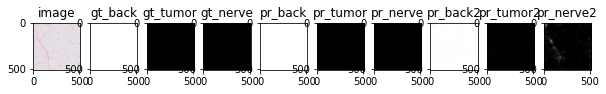

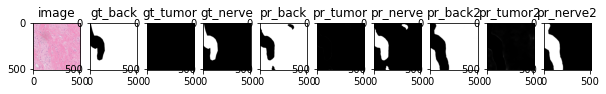

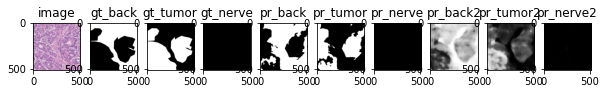

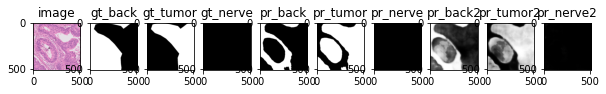

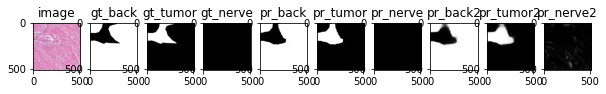

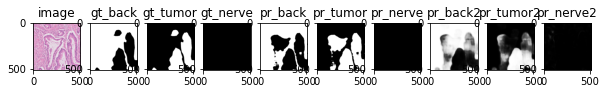

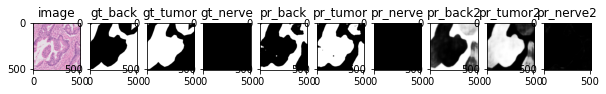

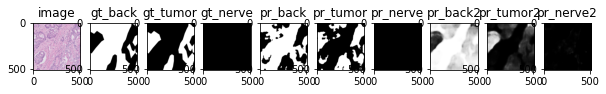

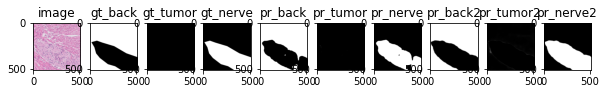

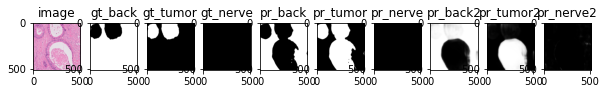

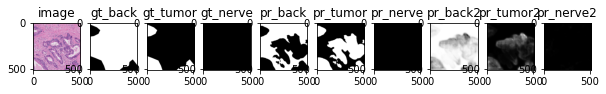

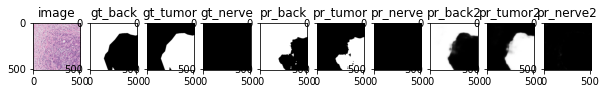

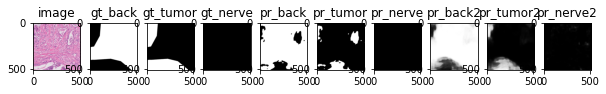

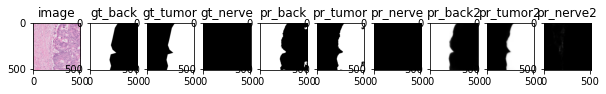

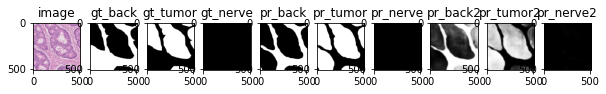

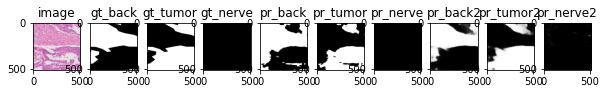

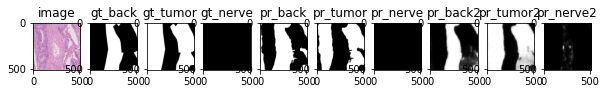

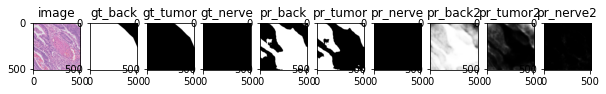

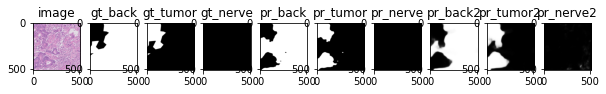

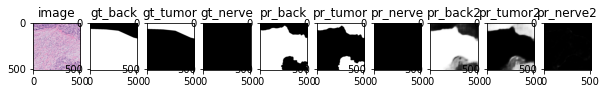

In [110]:
batch_x, batch_y = next(it)
for i in range(20):
    plt.figure()
    model_input = np.expand_dims(batch_x[i],0)
    plt.subplot(1,10,1); plt.title('image'); plt.imshow(np.array(batch_x[i]))
    plt.subplot(1,10,2); plt.title('gt_back'); plt.imshow(np.array(batch_y[i][...,0]),vmin=0,vmax=1)
    plt.subplot(1,10,3); plt.title('gt_tumor'); plt.imshow(np.array(batch_y[i][...,1]),vmin=0,vmax=1)
    plt.subplot(1,10,4); plt.title('gt_nerve'); plt.imshow(np.array(batch_y[i][...,2]),vmin=0,vmax=1)
    pred_prob = mdl.predict(model_input)
    pred_prob_back = pred_prob[...,0]
    pred_prob_tumor = pred_prob[...,1]
    pred_prob_nerve = pred_prob[...,2]
    
    pred_prob2 = mdl2.predict(model_input)
    pred_prob_back2 = pred_prob2[...,0]
    pred_prob_tumor2 = pred_prob2[...,1]
    pred_prob_nerve2 = pred_prob2[...,2]
    
    
    #plt.subplot(1,10,5); plt.title('pr_prob'); plt.imshow((pred_prob).squeeze())
    plt.subplot(1,10,5); plt.title('pr_back'); plt.imshow(pred_prob_back.squeeze())
    plt.subplot(1,10,6); plt.title('pr_tumor'); plt.imshow(pred_prob_tumor.squeeze())
    plt.subplot(1,10,7); plt.title('pr_nerve'); plt.imshow(pred_prob_nerve.squeeze())
    
    #plt.subplot(1,10,5); plt.title('pr_prob2'); plt.imshow((pred_prob2).squeeze())
    plt.subplot(1,10,8); plt.title('pr_back2'); plt.imshow(pred_prob_back2.squeeze())
    plt.subplot(1,10,9); plt.title('pr_tumor2'); plt.imshow(pred_prob_tumor2.squeeze())
    plt.subplot(1,10,10); plt.title('pr_nerve2'); plt.imshow(pred_prob_nerve2.squeeze())

---

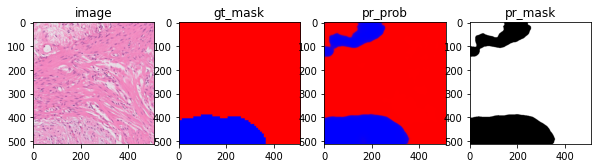

In [58]:
batch_x , batch_y = next(it)
for i in range(1):
    plt.figure()
    model_input = np.expand_dims(batch_x[i],0)
    pred_prob = mdl.predict(model_input)
    pred_mask = np.where(pred_prob>0.5,1,0)
    plt.subplot(1,4,1); plt.title('image'); plt.imshow(np.array(batch_x[i]))
    plt.subplot(1,4,2); plt.title('gt_mask'); plt.imshow(np.array(batch_y[i]))
    plt.subplot(1,4,3); plt.title('pr_prob'); plt.imshow(np.array(pred_prob).squeeze())
    plt.subplot(1,4,4); plt.title('pr_mask_nerve'); plt.imshow(np.array(pred_mask[...,0]).squeeze())
    plt.subplot(1,4,4); plt.title('pr_mask_tumor'); plt.imshow(np.array(pred_mask[...,1]).squeeze())
    plt.subplot(1,4,4); plt.title('pr_mask_tumor'); plt.imshow(np.array(pred_mask[...,2]).squeeze())
    
    

In [27]:
np.array([[0,0,0],[0,0,0],[0,0,0]]).shape

(3, 3)

In [31]:
import tensorflow.keras.backend as K


In [38]:
tf.constant(np.array([1,2,3]))

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([1, 2, 3])>

In [33]:
K.sum([[1,2,3,4,5]])

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [162]:
dice_loss = sm.losses.DiceLoss(per_image=True,smooth = 1e-5,)

In [147]:
focal_loss = sm.losses.BinaryFocalLoss()

In [141]:
tst_msk2[:128][:][:] =1.0

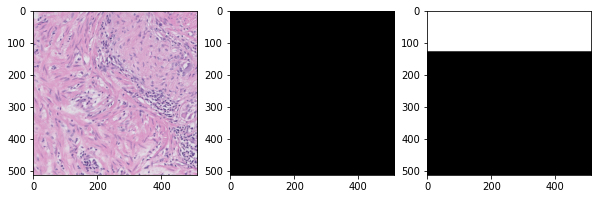

In [186]:
plt.figure();
plt.subplot(1,3,1); plt.imshow(tst)
plt.subplot(1,3,2); plt.imshow(tst_msk)
plt.subplot(1,3,3); plt.imshow(tst_msk2)

In [194]:
smth = 1e+2
dice_loss = sm.losses.DiceLoss(per_image=True,smooth = smth,class_weights = np.array([1]))
focal_loss = sm.losses.BinaryFocalLoss()
cat_loss = sm.losses.BinaryCELoss()
print(
    dice_loss(np.reshape(tst_gt,(-1,512,512)),np.reshape(tst_pr,(-1,512,512))),'\n',
    focal_loss(np.reshape(tst_gt,(-1,512,512)),np.reshape(tst_pr,(-1,512,512))),'\n',
    cat_loss(np.reshape(tst_gt,(-1,512,512)),np.reshape(tst_pr,(-1,512,512))),'\n',
    '-- gt is not blank pr is blank --\n',
    dice_loss(np.reshape(tst_gt,(-1,512,512)),np.reshape(tst_msk,(-1,512,512))),'\n',
    focal_loss(np.reshape(tst_gt,(-1,512,512)),np.reshape(tst_msk,(-1,512,512))),'\n',
    cat_loss(np.reshape(tst_gt,(-1,512,512)),np.reshape(tst_msk,(-1,512,512))),'\n',
    '-- gt is blank pr is not blank --\n',
    dice_loss(np.reshape(tst_msk,(-1,512,512)),np.reshape(tst_gt,(-1,512,512))),'\n',
    focal_loss(np.reshape(tst_msk,(-1,512,512)),np.reshape(tst_gt,(-1,512,512))),'\n',
    cat_loss(np.reshape(tst_msk,(-1,512,512)),np.reshape(tst_gt,(-1,512,512))),'\n',
    
)

tf.Tensor(0.07541692, shape=(), dtype=float32) 
 tf.Tensor(0.029652752, shape=(), dtype=float32) 
 tf.Tensor(0.08191393, shape=(), dtype=float32) 
 -- gt is not blank pr is blank --
 tf.Tensor(0.9982859, shape=(), dtype=float32) 
 tf.Tensor(0.89523077, shape=(), dtype=float32) 
 tf.Tensor(3.4269288, shape=(), dtype=float32) 
 -- gt is blank pr is not blank --
 tf.Tensor(0.9982859, shape=(), dtype=float32) 
 tf.Tensor(2.6564147, shape=(), dtype=float32) 
 tf.Tensor(3.4065542, shape=(), dtype=float32) 



In [40]:
tst_img = img_batch[-1]
tst_gt = msk_batch[-1]
tst_pr = pred_prob
plt.figure(); 
plt.subplot(1,3,1); plt.imshow(tst_img); 
plt.subplot(1,3,2); plt.imshow(tst_gt); 
plt.subplot(1,3,3); plt.imshow(tst_pr); 

NameError: name 'img_batch' is not defined

In [163]:
print(
    dice_loss(tst_msk2,tst_msk),'\n',
    dice_loss(tst_msk,tst_msk2),'\n',
    focal_loss(tst_msk,tst_msk2),'\n',
    focal_loss(tst_msk2,tst_msk)
)


tf.Tensor(0.25, shape=(), dtype=float32) 
 tf.Tensor(0.25, shape=(), dtype=float32) 
 tf.Tensor(2.9891965, shape=(), dtype=float32) 
 tf.Tensor(1.0073806, shape=(), dtype=float32)


In [62]:
tst = np.array(batch_x[0])

In [63]:
tst.shape

(512, 512, 3)

In [111]:
tst_msk = np.zeros_like(tst)
tst_msk2 = tst_msk.copy()

In [60]:
loss(
    tf.constant(np.reshape(np.array([[0,1,1],[1,1,0],[0,0,0]],dtype=np.float32),(-1,512,512,3))),
    tf.constant(np.reshape(np.array([[0,0,0],[0,0,0],[0,0,0]],dtype=np.float32),(-1,3,3,1))),
)

<tf.Tensor: shape=(), dtype=float32, numpy=0.28571427>

In [48]:
sm.losses.dice_loss(
    tf.constant(np.reshape(np.array([[0,1,1],[1,1,0],[0,0,0]],dtype=np.float32),(-1,3,3,1))),
    tf.constant(np.reshape(np.array([[0,0,0],[0,0,0],[0,0,0]],dtype=np.float32),(-1,3,3,1))),
)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9999975>

In [42]:
t = pred_prob.squeeze()

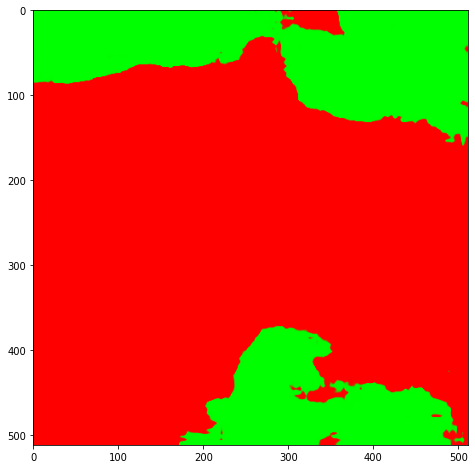

In [43]:
plt.imshow((t*255).astype(np.uint8))

In [55]:
print(t.dtype,t.shape)

float32 (512, 512, 3)


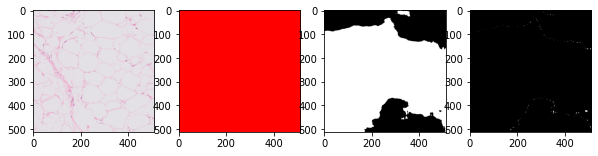

In [58]:
t_thr = cv.threshold(t[...,0].astype(np.uint8),127,255,cv.THRESH_BINARY|cv.THRESH_OTSU)[1]
t_adthr = cv.adaptiveThreshold(t[...,0].astype(np.uint8),255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY_INV,11,1)
plt.subplot(1,4,1);plt.imshow(np.array(batch_x[0]).squeeze())
plt.subplot(1,4,2);plt.imshow(np.array(batch_y[0]).squeeze())
plt.subplot(1,4,3);plt.imshow(t_thr)
plt.subplot(1,4,4);plt.imshow(t_adthr)

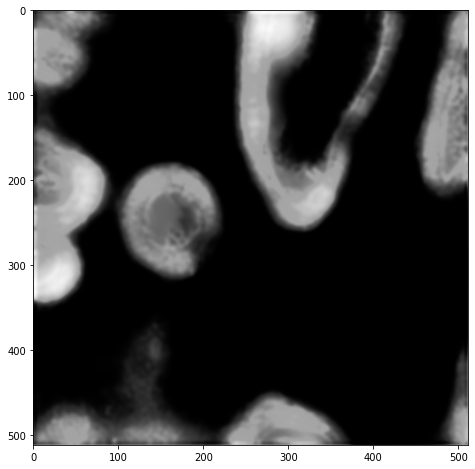

In [24]:
plt.imshow(t)

## BINARY

In [32]:
#mdl = build_seg_model('deeplab',)
#mdl.load_weights('./model/nerve_100_deeplab_xception_pascal_voc_0930dice_cross.hdf5')
idx = 1
mdl = build_seg_model(
    mdls[idx],
    backbone=backbones[idx],
    weight=weights[idx]
)

mdl.load_weights(mdl_paths[idx])
idx = -1
mdl2 = build_seg_model(
    mdls[idx],
    backbone=backbones[idx],
    weight=weights[idx]
)
mdl2.load_weights(mdl_paths[idx])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


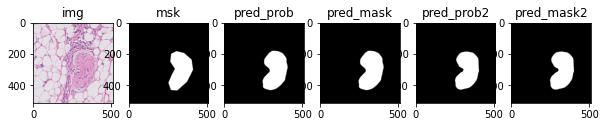

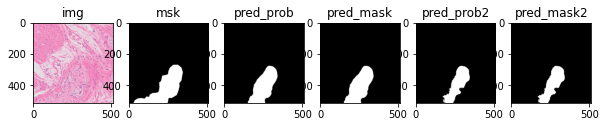

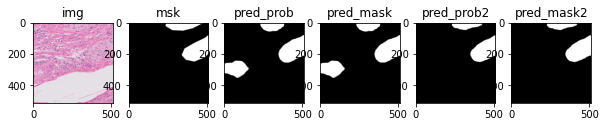

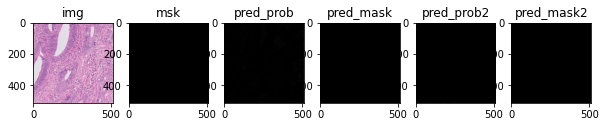

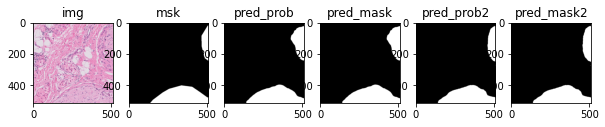

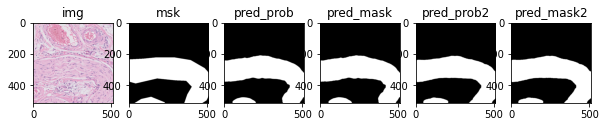

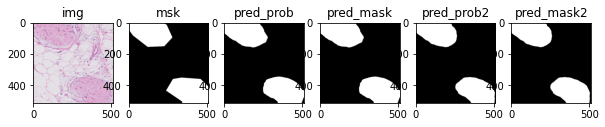

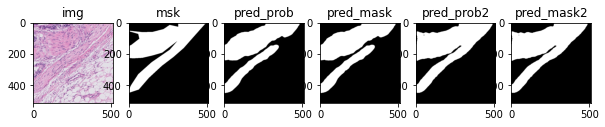

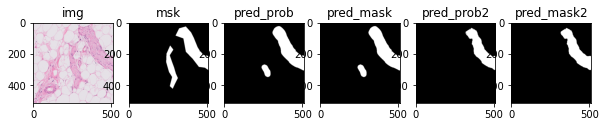

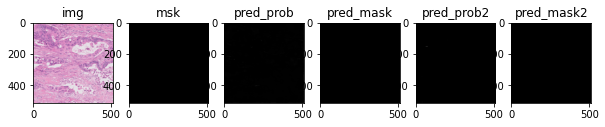

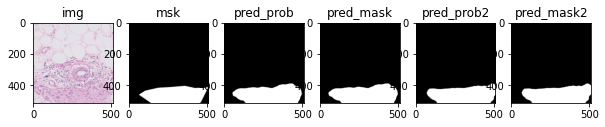

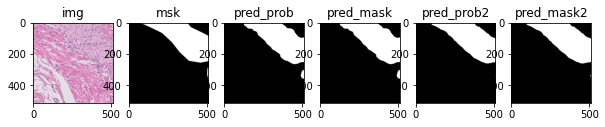

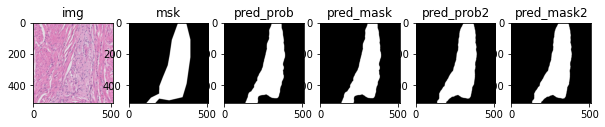

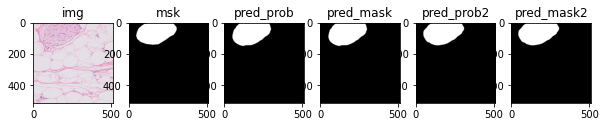

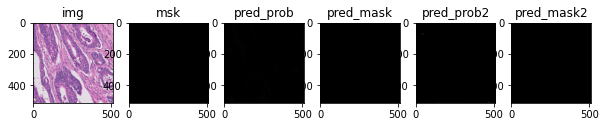

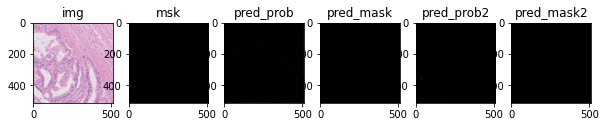

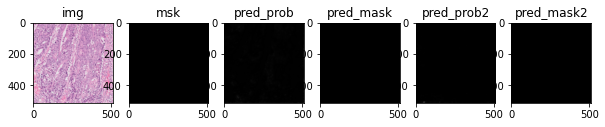

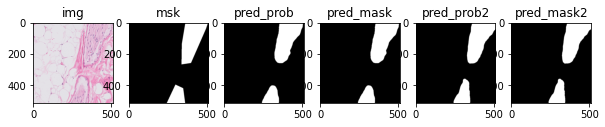

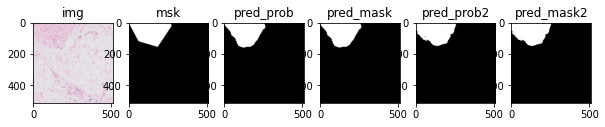

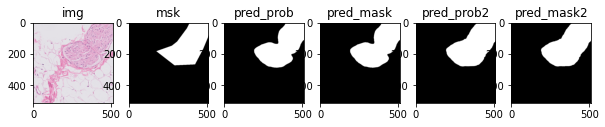

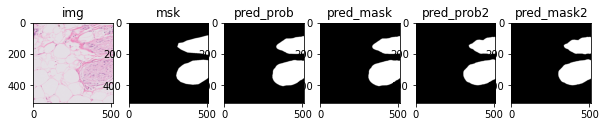

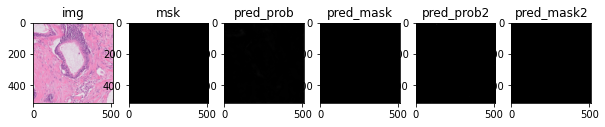

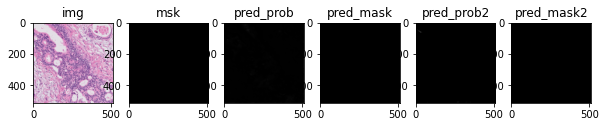

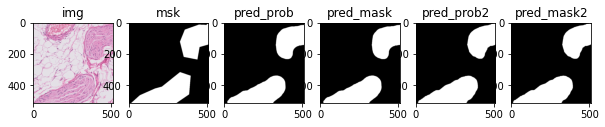

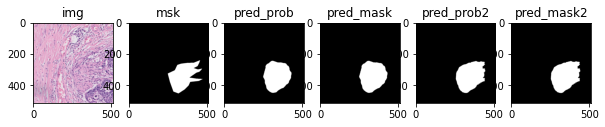

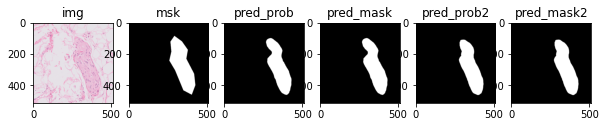

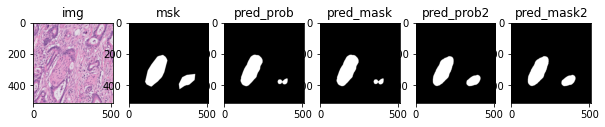

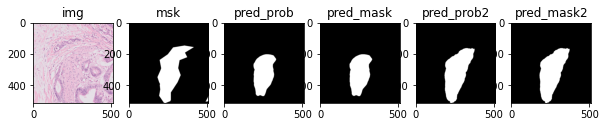

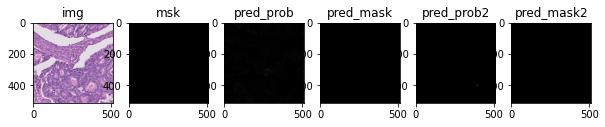

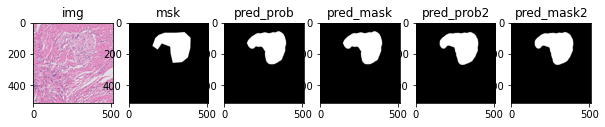

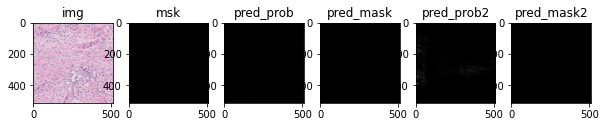

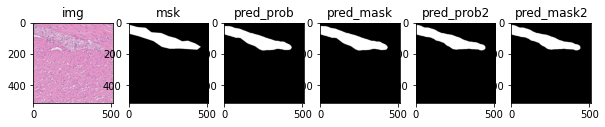

In [33]:
batch_set = test_set.take(1)
for img_batch,msk_batch in batch_set:
    for i in range(32):
        img_input = np.expand_dims(img_batch[i],axis =0)
        pred_prob = np.squeeze(mdl.predict(img_input))
        pred_mask = np.logical_and(pred_prob>0.5,1)
        
        pred_prob2 = np.squeeze(mdl2.predict(img_input))
        pred_mask2 = np.logical_and(pred_prob2>0.5,1)
        
        plt.figure()
        plt.subplot(1,6,1); plt.title('img') ; plt.imshow(img_batch[i])
        plt.subplot(1,6,2); plt.title('msk') ; plt.imshow(msk_batch[i])
        plt.subplot(1,6,3); plt.title('pred_prob') ; plt.imshow(pred_prob)
        plt.subplot(1,6,4); plt.title('pred_mask') ; plt.imshow(pred_mask)
        plt.subplot(1,6,5); plt.title('pred_prob2') ; plt.imshow(pred_prob2)
        plt.subplot(1,6,6); plt.title('pred_mask2') ; plt.imshow(pred_mask2)
        
        